In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LinearRegression

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

# First Dataset: Danenberg et al. 2022

In [ ]:
df = pd.read_parquet("Danenberg2022.parquet", engine="pyarrow")
df.head()

beta_2_microglobulin     cd11c  cd31_v_wf      cd16  \
sample_id  object_id                                                        
MB_0000_64 1                      0.053804  0.069920   0.120143  0.006377   
           2                      0.375092  0.043020   0.441314  0.142209   
           3                      0.777369  0.066990   1.046369  0.314355   
           4                      0.131215  0.050163   0.336800  0.025421   
           5                      0.293895  0.000000   0.485267  0.053376   

                          cd15    cd45ra  cytokeratin_8_18     foxp3  \
sample_id  object_id                                                   
MB_0000_64 1          0.029040  0.099387          0.009369  0.084630   
           2          0.050266  0.323284          0.013078  0.032413   
           3          0.102586  0.735592          0.038628  0.002340   
           4          0.024222  0.155477          0.025329  0.021282   
           5          0.074288  0.163064          0.000000  0.067333   

                          fsp1  caveolin_1  ...  cd140b_pdgf_receptor_beta  \
sample_id  object_id                        ...                              
MB_0000_64 1          0.061353    0.778798  ...                   0.402452   
           2          0.260911    0.248921  ...                   0.419127   
           3          1.066429    1.263901  ...                   0.630600   
           4          0.212466    0.096149  ...                   0.327654   
           5          0.000000    1.223854  ...                   0.559281   

                           dna2  estrogen_receptor_alpha    hla_dr  \
sample_id  object_id                                                 
MB_0000_64 1          27.494448                 0.844442  0.417351   
           2          17.375443                 5.737365  4.390213   
           3          23.676686                 3.020475  3.382875   
           4          19.898480                 1.402375  0.607057   
           5          15.515278                 0.498736  3.009397   

                      podoplanin  cleaved_caspase3  cd279_pd_1  gitr_tnfrsf18  \
sample_id  object_id                                                            
MB_0000_64 1            0.040373          0.012871    0.155926       0.017983   
           2            0.108923          0.064592    0.049194       0.072653   
           3            0.170306          0.117730    0.220807       0.074819   
           4            0.061865          0.050812    0.042806       0.057253   
           5            0.024786          0.137710    0.229752       0.083210   

                          cd57       cd4  
sample_id  object_id                      
MB_0000_64 1          0.020535  0.085333  
           2          0.107952  0.305251  
           3          0.320959  0.692535  
           4          0.037038  0.176990  
           5          0.000000  0.291941  

[5 rows x 39 columns]

In [ ]:
df_meta = pd.read_parquet("Danenberg2022-metadata.parquet", engine="pyarrow")

df_meta.head()

image_number metabric_id        cell_phenotype  \
sample_id  object_id                                                   
MB_0000_64 1                    64     MB-0000           Endothelial   
           2                    64     MB-0000           Fibroblasts   
           3                    64     MB-0000  Fibroblasts FSP1^{+}   
           4                    64     MB-0000       CD8^{+} T cells   
           5                    64     MB-0000           Fibroblasts   

                      is_epithelial  is_tumour  is_normal  is_dcis  \
sample_id  object_id                                                 
MB_0000_64 1                      0          1          0        0   
           2                      0          1          0        0   
           3                      0          1          0        0   
           4                      0          1          0        0   
           5                      0          1          0        0   

                      is_interface  is_perivascular  is_hot_aggregate  \
sample_id  object_id                                                    
MB_0000_64 1                     0                0                 0   
           2                     0                0                 0   
           3                     0                0                 0   
           4                     0                0                 0   
           5                     0                0                 0   

                      location_center_x  location_center_y  area_shape_area  \
sample_id  object_id                                                          
MB_0000_64 1                  27.262963          15.755556              270   
           2                   7.602273          20.840909              264   
           3                  44.254902          25.686275              102   
           4                  18.357143          31.188312              154   
           5                  34.944444          29.388889               36   

                                     label  
sample_id  object_id                        
MB_0000_64 1                   endothelial  
           2                   fibroblasts  
           3          fibroblasts_fsp1_pos  
           4               cd8_pos_t_cells  
           5                   fibroblasts

In [ ]:
print(set(df_meta.label))

{'mhc_i_and_ii_hi', 'basal', 'ck_lo_er_med', 'cd4_pos_t_cells_and_apcs', 'ck_pos_cxcl12_pos', 'fibroblasts', 'myofibroblasts', 'cd57_pos', 'cd38_pos_lymphocytes', 'cd8_pos_t_cells', 'mhc_hi_cd15_pos', 'ep_ki67_pos', 'granulocytes', 'endothelial', 'myofibroblasts_pdpn_pos', 'cd4_pos_t_cells', 'cd15_pos', 'ki67_pos', 'ck_med_er_lo', 'b_cells', 'fibroblasts_fsp1_pos', 'ck8_18_hi_cxcl12_hi', 'mhc_i_hi_cd57_pos', 'her2_pos', 't_reg_and_t_ex', 'macrophages', 'er_hi_cxcl12_pos', 'ck8_18_pos_er_hi', 'ep_cd57_pos', 'macrophages_and_granulocytes', 'ck8_18_hi_er_lo', 'ck_lo_er_lo'}


## Normalization

In [ ]:
def norm(data, idv):
  '''
  Normalization
  '''
  #step 1: regressing out systematic noise
  df_residuals = pd.DataFrame(index=data.index, columns=data.columns)

  for marker in data.columns:
    y = data[marker].values.reshape(-1, 1)

    model = LinearRegression().fit(idv, y)
    y_pred = model.predict(idv)
    residuals = (y - y_pred).ravel()
    df_residuals[marker] = residuals

  # Step 2: arcsinh normalization
  scFac=5
  scaled_data=np.arcsinh(df_residuals/scFac)

  # Step 3: Z-transform
  scaler = StandardScaler()
  z_data = scaler.fit_transform(scaled_data)

  z_data = pd.DataFrame(z_data, columns=data.columns, index=data.index)

  return z_data




In [ ]:
#normalization - option a by total signal
# Step 1: Residuals to account for systematic effects
total_intensity = df.sum(axis=1).values.reshape(-1, 1)
h3_intensity = df["histone_h3"].values.reshape(-1, 1) # Reshape to 2D array

norm_data_t = norm(df, total_intensity)
norm_data_h3 = norm(df, h3_intensity)

In [ ]:
norm_data_t.head()

beta_2_microglobulin     cd11c  cd31_v_wf      cd16  \
sample_id  object_id                                                        
MB_0000_64 1                     -0.569345 -0.324407  -0.477041 -0.548672   
           2                     -0.279640 -0.493231   0.267601 -0.108124   
           3                      0.040708 -0.455351   1.626988  0.437330   
           4                     -0.486320 -0.417721   0.049311 -0.483421   
           5                     -0.307531 -0.655006   0.430060 -0.384699   

                          cd15    cd45ra  cytokeratin_8_18     foxp3  \
sample_id  object_id                                                   
MB_0000_64 1          0.002484 -0.608252         -0.057832  0.609912   
           2          0.000144 -0.438753         -0.088765 -0.123265   
           3         -0.031075 -0.209983         -0.200849 -0.627381   
           4          0.009123 -0.532133         -0.027302 -0.235498   
           5          0.071438 -0.466199          0.002391  0.424530   

                          fsp1  caveolin_1  ...  cd140b_pdgf_receptor_beta  \
sample_id  object_id                        ...                              
MB_0000_64 1         -0.452677    0.043912  ...                  -0.098786   
           2          0.058310   -0.351068  ...                  -0.066656   
           3          2.113490    0.373684  ...                   0.368295   
           4         -0.053432   -0.454018  ...                  -0.255154   
           5         -0.594014    0.382476  ...                   0.239061   

                          dna2  estrogen_receptor_alpha    hla_dr  podoplanin  \
sample_id  object_id                                                            
MB_0000_64 1          0.757427                 0.407935 -0.375673   -0.529736   
           2         -0.498636                 0.777608  1.443913   -0.340684   
           3         -0.525345                -0.067066  0.995309   -0.235153   
           4          0.091515                 0.546522 -0.283584   -0.451672   
           5         -0.153768                 0.627714  0.857941   -0.535069   

                      cleaved_caspase3  cd279_pd_1  gitr_tnfrsf18      cd57  \
sample_id  object_id                                                          
MB_0000_64 1                 -0.316122    0.636407      -0.640800  0.101098   
           2                 -0.173209   -0.060327      -0.103449  0.099711   
           3                 -0.117982    0.936004      -0.208085  0.033722   
           4                 -0.169569   -0.065323      -0.212708  0.133567   
           5                  0.170112    1.147494       0.104642  0.177474   

                           cd4  
sample_id  object_id            
MB_0000_64 1         -0.699363  
           2         -0.291659  
           3          0.363816  
           4         -0.500219  
           5         -0.228937  

[5 rows x 39 columns]

## Binary classification of epithelial vs. non-epithelial (TME) cells
this is a key distinction of cells in breast tumor tissues

In [ ]:
def cytof_analysis(df_data, df_meta, norm_method, random=False):
    """
    Performs classification:
    - binary: epithelial/non-epithelial (TME)
    - multi-class: TME subtypes

    Parameters:
    - df_data: pd.DataFrame, normalized data.
    - df_meta: pd.DataFrame, must contain columns 'is_epithelial' and 'label' for subtype information.
    - norm_method: str, label for the normalization method used (for reporting purposes).

    Returns:
    - dict containing binary and multi-class classification metrics.
    """

    X = df_data
    y = df_meta.is_epithelial.to_numpy()

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    auc_scores = []
    print("...training xgb epithelial vs TME")
    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        params = {
            'objective': 'binary:logistic',
            'device': 'cuda',
            'eval_metric': 'auc'
        }

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=300,
            evals=[(dtest, 'test')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        y_pred_prob = bst.predict(dtest)
        y_pred = (y_pred_prob > 0.5).astype(int)

        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)

        f1_scores.append(f1)
        auc_scores.append(auc)

    binary_results = {
        "Mean F1 Score": np.mean(f1_scores),
        "Mean AUC Score": np.mean(auc_scores)
    }

    # Multi-class classification (non-epithelial subtypes)
    X_nonepi = X[y == 0]
    y_nonepi = df_meta.label[y == 0]

    X_train, X_test, y_train, y_test = train_test_split(X_nonepi, y_nonepi, test_size=0.2, random_state=42, stratify=y_nonepi)


    if random:
      baseline_distribution = pd.Series(y_test).value_counts(normalize=True)
      return baseline_distribution

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    dtrain_epi = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest_epi = xgb.DMatrix(X_test, label=y_test_encoded)

    params_multi = {
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'device': 'cuda',
        'eval_metric': ['mlogloss', 'merror']
    }
    print("...training xgb per cell type")
    bst_multi = xgb.train(params_multi, dtrain_epi,
                          num_boost_round=100,
                          evals=[(dtest_epi, 'test')],
                          early_stopping_rounds=10,
                          verbose_eval=False)

    y_pred_prob_multi = bst_multi.predict(dtest_epi)
    y_pred_multi = np.argmax(y_pred_prob_multi, axis=1)

    f1_multi = f1_score(y_test_encoded, y_pred_multi, average='weighted')
    accuracy_multi = accuracy_score(y_test_encoded, y_pred_multi)

    multi_results = {
        "Multi-Class Accuracy": accuracy_multi,
        "Multi-Class F1 Score": f1_multi
    }

    # Per-subtype accuracy
    y_pred_labels = le.inverse_transform(y_pred_multi)
    y_true_labels = le.inverse_transform(y_test_encoded)

    per_class_acc = {}
    for label in np.unique(y_true_labels):
        mask = y_true_labels == label
        acc = accuracy_score(y_true_labels[mask], y_pred_labels[mask])
        per_class_acc[label] = acc

    sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True)

    return {
        "binary_classification": binary_results,
        "multi_class_classification": multi_results,
        "per_subtype_accuracy": sorted_acc
    }

In [ ]:
results_t = cytof_analysis(norm_data_t, df_meta, norm_method="total")


In [ ]:
results_h3 = cytof_analysis(norm_data_h3, df_meta, norm_method="H3")


In [ ]:
results_rnd = cytof_analysis(norm_data_h3, df_meta, norm_method="H3", random=True)


...training xgb epithelial vs TME


In [ ]:
def plot_comparison(results1, results2, baseline_distribution, method1="Method 1", method2="Method 2", method3="Baseline (Class Proportion)"):

    # Extract all labels from both result sets and the baseline
    labels = sorted({label for res in [results1, results2] for label, _ in res["per_subtype_accuracy"]} | set(baseline_distribution.index))

    # Helper to extract accuracy scores aligned with labels
    def get_scores(results):
        accuracy_dict = dict(results["per_subtype_accuracy"])
        return [accuracy_dict.get(label, 0) for label in labels]

    # Extract scores from the first two result sets
    scores1 = get_scores(results1)
    scores2 = get_scores(results2)
    # Extract baseline scores from the class proportion distribution
    scores3 = [baseline_distribution.get(label, 0) for label in labels]

    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(12, 8))
    plt.barh(x - width, scores1, width, label=method1, color='lightcoral')
    plt.barh(x, scores2, width, label=method2, color='skyblue')
    plt.barh(x + width, scores3, width, label=method3, color='lightgrey')

    plt.xlabel('Accuracy')
    plt.ylabel('Subtype')
    plt.yticks(x, labels)
    plt.xlim(0, 1.0)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

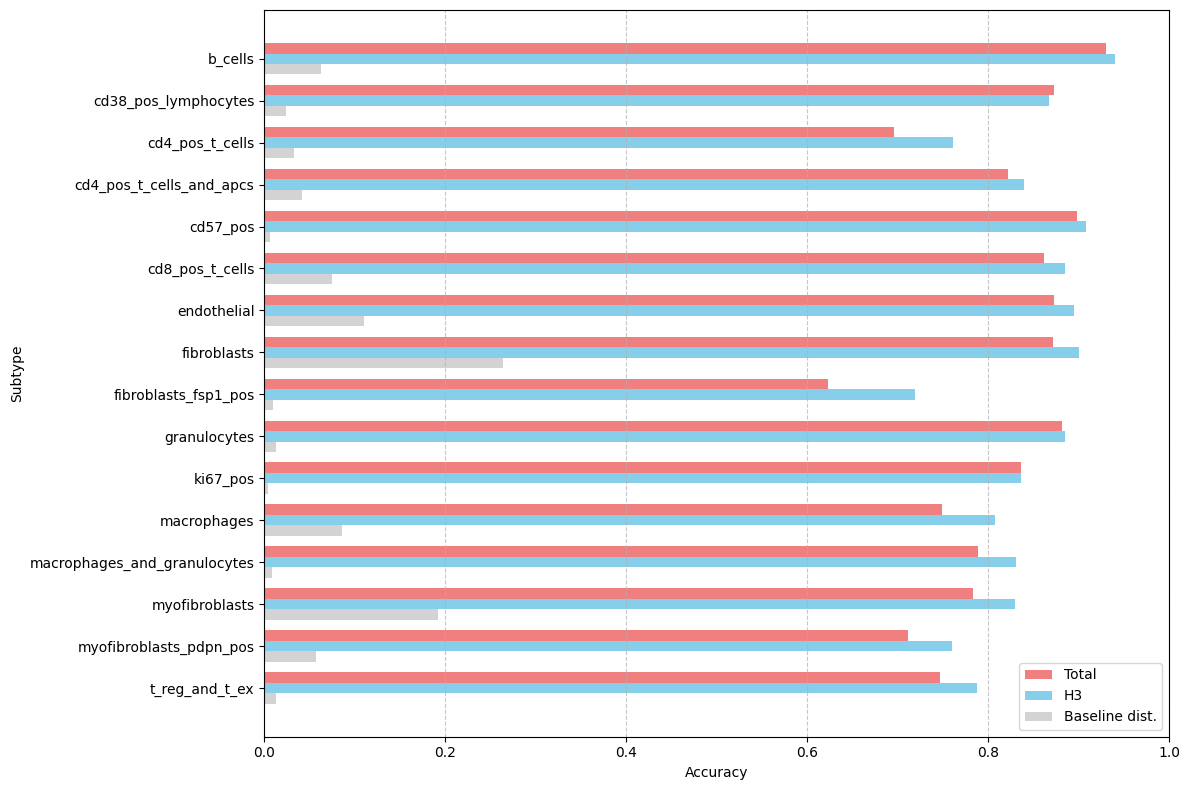

In [ ]:
plot_comparison(results_t, results_h3, results_rnd, "Total", "H3", "Baseline dist.")

Stromal cell heterogeneity might be evident by the relatively lower accuracy for myofibroblasts and fibroblasts, in line with this human study ([Danenberg 2022](https://https://www.nature.com/articles/s41588-022-01041-y) ) and another mice study ([Friedman 2020](https://https://pubmed.ncbi.nlm.nih.gov/35122040/))